**Summary**

This notebook was an attempt to classify defensive coverages from the 2018 NFL season based on defensive player locations on the field at the snap and in the first few moments after the play began. Those player locations were provided as x,y Cartesian coordinates for each defensive player in coverage and all offensive skill positions as well as the Quarterback. We apply KMeans as an Unsupervised Machine Learning Algorithm and analyze the results. 

The KMeans algorithm attempts to bin each example (play) into a specified number of bins based on similarity of each example's features. The goal in implementing this algorithm was to distinguish the type of coverage at a high level (man vs zone) or even more granularly (Cover 0, Cover 1, Cover 2, Cover 3, etc.). The features provided were the defensive player locations in .1 sec increments over the first 2 seconds of the play - assumed to be enough time for a zone coverage to take shape or man coverage to appear more random with defenders mimicing offensive player movements.

The results of this analysis proved largely inconclusive as there was no clear clustering of two bins (Man vs Zone) or any larger number of bins for that matter. Further attempts to develop this project could incorporate the offensive player movements, explore different features derived from the player positions that would better capture their resemblence to a defined/structured zone coverage versus the relative unpredictability of player locations in man coverage. A different algorithm could be considered as well. 

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from functools import reduce
import matplotlib.pyplot as plt

Import the data into three dataframes. Combine all of the player tracking data for each of the 17 weeks of the season into a single dataframe

In [ ]:
path = '/kaggle/input/nfl-big-data-bowl-2021/'

games_df = pd.read_csv(path+'games.csv')#,iterator=True, chunksize=100_000)
players_df = pd.read_csv(path+'players.csv')#,iterator=True, chunksize=100_000)
plays_df = pd.read_csv(path+'plays.csv')#,iterator=True, chunksize=100_000)

plays_df['uniqueID'] = plays_df['gameId'].astype(str) + '_' + plays_df['playId'].astype(str)
plays_df.head()

tracking = list()
for i in range(1,18):
    tracking.append(pd.read_csv(path+'week{}.csv'.format(i)))
tracking_df = pd.concat(tracking)

The gameId and playId columns are not unique individually but when combined they form a unique ID for tracking the player positions for specific plays throughout the season

In [ ]:
tracking_df['uniqueID'] = tracking_df['gameId'].astype(str) + '_' + tracking_df['playId'].astype(str)
tracking_df.head()

Listing all of the positions seen in the data. Of note, there are 13 defensive positions in the data

In [ ]:
tracking_df['position'].unique()

In [ ]:
plays_df.head()

Implement a boolean field to track which players are on defense

In [ ]:
defenders = ['SS', 'FS', 'MLB', 'CB', 'LB', 'OLB', 'ILB', 'DL', 'DB', 'NT', 'S', 'DE', 'DT']
tracking_df['Is Defender'] = tracking_df['position'].isin(defenders)

Normalize player tracking data to all be in the Right direction so comparisons can be made properly

In [ ]:
tracking_df.loc[tracking_df['playDirection'] == 'left', 'x'] = tracking_df[tracking_df['playDirection'] == 'left']['x'].apply(lambda x: 120 - x)

Discovered that tracking data is not available for all 22 players on the field in a given play
Player data for defenders is only tracked if they are in coverage. Count how many defenders are tracked per play

In [ ]:
defender_counts = tracking_df[(tracking_df['Is Defender'] == True) & (tracking_df['frameId'] == 1)].groupby('uniqueID').size().reset_index(name='Defender Count')
tracking_df = tracking_df.merge(defender_counts, on='uniqueID')

tracking_df.tail()

Calculated the most frequent number of players in coverage per play and kept that group to produce more uniform dataset. Will filter to just plays with 7 defenders in coverage. Plays with more than 11 defenders in coverage appear to mostly be edge cases such as fake punt passes

In [ ]:
tracking_df.groupby(['Defender Count']).size()

Uniform training data is required as the input for the KMeans algorithm is a matrix of features. Inconsistent numbers of players tracked on a play will lead to inconsistent vector dimensions comprising of the matrix. If tracking data was available for all 11 players on defense - or all 22 players on the field total - we would use that as our uniform training set.

In [ ]:
num_defenders = 7
tracking_df = tracking_df[tracking_df['Defender Count'] == num_defenders]
tracking_df.columns

The tracking data for each player for a given frame (.1 sec) in a given play is an individual row in the dataframe. In order to present each player position at each frame as a feature in the KMeans algorithm, we need to create a dataframe where each column is a defensive player in coverage and the row is their location during each frame in each play during the 2018 season.

A defensive coverage is only shown in it's original form during the first few seconds of a passing play. From there, either the ball is thrown and the defenders converge on the target, or the coverage breaks down as the play progresses. For this reason, only the first few seconds of each play were considered valuable training data. In order to determine an appropriate snapshot time length for the training set, the average time to throw needed to be considered. For 2018, this was between 2-3 seconds per NFL Next Gen Stats, thus a 2 second snapshot length was chosen to produce the cleanest but most informative training set.

Next Gen Stats 2018 Time to Throw: https://nextgenstats.nfl.com/stats/passing/2018/REG/all#average-time-to-throw

In [ ]:
#Grab player positions at snap (frameID=1) and s seconds into play
#frameID iterates every .1sec

snapshot_time = 2
snap = 1
snapshot_frames = int(snapshot_time*10+1)

snapshot_df = tracking_df[tracking_df['frameId'] == 1]
snapshot_df = snapshot_df[['uniqueID', 'playDirection', 'nflId', 'displayName', 'jerseyNumber', 'position', 'team', 'Is Defender', 'Defender Count', 'x', 'y']]
snapshot_df = snapshot_df.rename(columns={'x' : 'x_frame1', 'y' : 'y_frame1'})
#print("Frame 1 cols: {}".format(snapshot_df.columns))
for s in range(2,snapshot_frames):
    temp_df = tracking_df[tracking_df['frameId'] == s]
    temp_df = temp_df[['uniqueID', 'playDirection', 'nflId', 'displayName', 'jerseyNumber', 'position', 'team', 'Is Defender', 'Defender Count', 'x', 'y']]
    temp_df = temp_df.rename(columns={'x' : 'x_frame{}'.format(s), 'y' : 'y_frame{}'.format(s)})
    #print("Frame {} cols: {}".format(s, temp_df.columns))
    snapshot_df = snapshot_df.merge(temp_df, on=['uniqueID', 'playDirection', 'nflId', 'displayName', 'jerseyNumber', 'position', 'team', 'Is Defender', 'Defender Count'])

In [ ]:
snapshot_df.columns

Now we have a dataframe where each row is a uniqueID -  a particular frame within the first two seconds of a pass play - and the columns include the Cartesian coordinates of each defensive player in coverage on that play.

In [ ]:
ball_pos = snapshot_df[(snapshot_df['position']).isna()][['uniqueID', 'x_frame1', 'y_frame1']].rename(columns={'x_frame1': 'ball_x', 'y_frame1': 'ball_y'})
defenders = snapshot_df[(snapshot_df['Is Defender'] == True)].groupby('uniqueID')
dfs = [ball_pos]
for s in range(1, snapshot_frames):
    x = defenders['x_frame{}'.format(s)].apply(list).reset_index(name='defenders_x_frame{}'.format(s))
    y = defenders['y_frame{}'.format(s)].apply(list).reset_index(name='defenders_y_frame{}'.format(s))
    dfs.append(x)
    dfs.append(y)
    
distance_metrics = reduce(lambda left,right: pd.merge(left, right, on='uniqueID'), dfs)

It should be noted that the provided data will track player positions throughout the field of play, regardless what yardline the ball was spotted on to begin the play. For this reason, the x coordinate in the raw Cartesian data for each play carries some bias and should be normalized. Two different methods were considered for this:

Polar coordinates: Convert each set of Cartesian coordinates to a polar pair where the origin is the ball location when the play begins. Polar coordinates replace the typical (x,y) coordinate pair with a (distance, angle) pair relative to the origin. Thus each player will now be tracked throughout the play via their distance and angle from the original ball spot.

Normalized Cartesian coordinates: Maintain the Cartesian coordinate format but subtract the ball spot yardline from the x coordinate to produce a dataset where all of the tracking data starts from the same point.

Note: I now realize that I should have normalized the y coordinate as well since the ball is spotted on different hashmarks depending on the previous play result. I didn't have time before the submission deadline to explore what impact this would have. The Polar coordinates do now have this issue at all since using the ball location as the origin removes the bias of both the x and y coordinate. 

In [ ]:
def distance(vec_x, vec_y, o_x, o_y):
    return np.sqrt((np.array(vec_x)-np.array([o_x]))**2 + (np.array(vec_y)-np.array([o_y]))**2)

In [ ]:
def angle(vec_x, vec_y, o_x, o_y):
    return np.degrees(np.arctan2(np.array(vec_y)-np.array([o_y]), np.array(vec_x)-np.array([o_x])))

In [ ]:
#Y coordinate is already normalized
#X coordinate needs to be normalized by subtracting the yardline at snap
def normalize_cartesian(vec_x, yardline):
    return np.array(vec_x) - np.array([yardline])

In [ ]:
for s in range(1, snapshot_frames):
    distance_metrics['distance_frame{}'.format(s)] = distance_metrics.apply(lambda row: distance(row['defenders_x_frame{}'.format(s)], row['defenders_y_frame{}'.format(s)], row['ball_x'], row['ball_y']), axis=1)
    distance_metrics['angle_frame{}'.format(s)] = distance_metrics.apply(lambda row: angle(row['defenders_x_frame{}'.format(s)], row['defenders_y_frame{}'.format(s)], row['ball_x'], row['ball_y']), axis=1)

    distance_metrics['defenders_xnorm_frame{}'.format(s)] = distance_metrics.apply(lambda row: normalize_cartesian(row['defenders_x_frame{}'.format(s)], row['ball_x']), axis=1)
    distance_metrics['defenders_xnorm_frame{}'.format(s)] = distance_metrics.apply(lambda row: normalize_cartesian(row['defenders_x_frame{}'.format(s)], row['ball_x']), axis=1)

In [ ]:
distance_metrics.head()

We now have a dataset ready to process via KMeans. The next step is to provide the algorithm with a desired number of bins - how many categories of defensive coverages each play could be categorized as.

In order to properly evaluate the best number of bins (k) in the KMeans algorithm, a common approach is the "elbow" method in which we evaluate the smallest k that garners a reasonably small Sum of Squared Error (SSE). In the plot of SSE over k, the "elbow" (shown in the red circle below) is typically the point at which any further increase in k does not yield a significant decrease in SSE, thus that k is the optimal number of bins determined for the training set.

Source: https://stackoverflow.com/questions/43784903/scikit-k-means-clustering-performance-measure

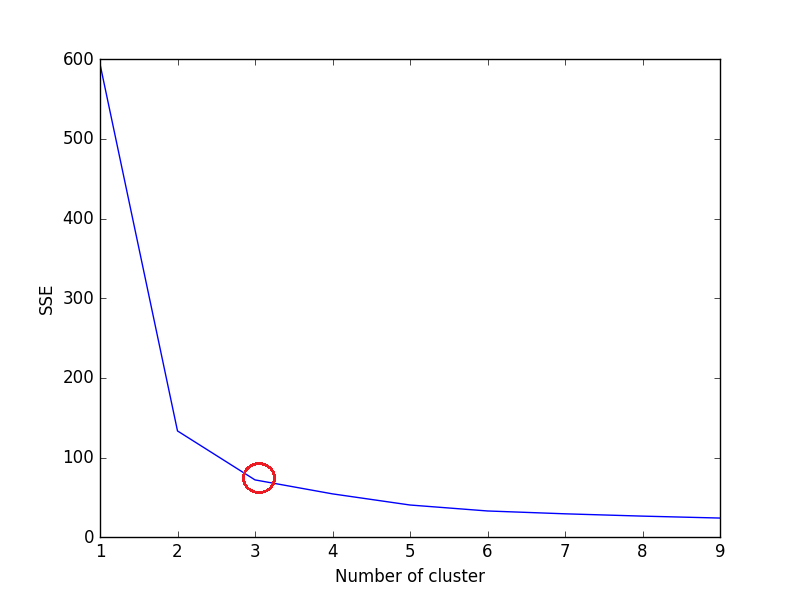

In [ ]:
def do_kmeans(X):
    scaler = StandardScaler()
    X_std = scaler.fit_transform(X)
    sse = {}
    for k in range(1, 15):
        kmeans = KMeans(n_clusters=k, max_iter=2000).fit(X_std)
        labels = kmeans.labels_
        sse[k] = kmeans.inertia_
    plt.figure()
    plt.plot(list(sse.keys()), list(sse.values()))
    plt.xlabel("Number of clusters")
    plt.ylabel("SSE")
    plt.show()
    return labels

Just as an intial test of the algorithm, we used the raw non-normalized Cartesian coordinates as our features. In somewhat of a surprise, this data actually produced the best looking elbow curve as shown below with an optimal k value of 3. However, this should probably be attributed to the known bias in the data. Perhaps the three bins may be three sections of the field where the play was run. A good less on how biased data can be misleading.

In [ ]:
#Cartesian coordinates; this contains bias towards the play location on the field
features = [x for x in distance_metrics.columns if 'defenders_x_' in x or 'defenders_y_' in x]
X = np.array(distance_metrics[features].values.tolist()).reshape(len(distance_metrics.index), len(features)*num_defenders)

labels = do_kmeans(X)

The Polar coordinates did not yiled nearly as convincing of an elbow curve. Some follow on online research has taught me that KMeans operates best with Cartesian coordinates so perhaps that has something to do with the poor result. 

Note: The Polar coordinate angles were calculated in degrees. Perhaps it would have been worthwhile to see if radians made a difference. Doubtful though since it is merely a linear scaling of the same data. 

In [ ]:
#Polar coordinates
features = [x for x in distance_metrics.columns if 'distance' in x or 'angle' in x]
X = np.array(distance_metrics[features].values.tolist()).reshape(len(distance_metrics.index), len(features)*num_defenders)
labels = do_kmeans(X)

Unfortunately, the Normalized Cartesian coordinates produced a similarly ambiguous elbow curve. This was rather disappointing considering the promise the raw Cartesian coordinates showed, despite the bias. Further research is needed here to determine how other feature scaling or altering of the data could improve the performance.

In [ ]:
#Normalized Cartesian coordinates
features = [x for x in distance_metrics.columns if 'xnorm' in x or 'defenders_y_' in x]

#Normalized Cartesian coordinates and Polar coordinates
#features = [x for x in distance_metrics.columns if 'xnorm' in x or 'defenders_y_' in x or 'angle' in x or 'distance' in x]

X = np.array(distance_metrics[features].values.tolist()).reshape(len(distance_metrics.index), len(features)*num_defenders)
labels = do_kmeans(X)

In order to explore how each training set was being clustered by the algorithm, the results were merged back into the dataframe and so random plays from each set could be plotted.

We selected k=2 to evaluate whether the algorithm could distinguish between Man and Zone Coverage.

In [ ]:
optimal_k = 2

In [ ]:
distance_metrics['kmeans_class'] = pd.Series(labels)

In [ ]:
distance_metrics[distance_metrics['kmeans_class'] == 1]

A very simple plotting function was put together to show the player positions at the snap, halfway through the snapshot, at the end of the snapshot, and finally as a culmination throughout the entire snapshot. Visual analysis of the first three plots offers some clarity into what the algorithm was presented with in order to perform the clustering. The final plot shows each player's location every .1 sec as a single point on the plot. Visual analysis of this shows a clear distinction between which plays are Man Coverage vs Zone. 

In [ ]:
def plot_play(df, df2, unique_id, snapshot_time, snapshot_frames):
    pd.set_option("display.max_colwidth", 10000)
    halfway_frame = int(snapshot_frames/2)
    halfway_time = int(snapshot_time/2)
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(30,10))
    defenders = df[(df['uniqueID'] == unique_id)]
    
    #dropping ball position
    defenders = defenders[defenders['position'].notna()]
    
    defenders['color_col'] = defenders['Is Defender'].astype(int)
    defenders.plot.scatter(x='y_frame{}'.format(1), y='x_frame{}'.format(1), c='color_col', colormap='plasma', ax=axes[0], title='At snap')
    defenders.plot.scatter(x='y_frame{}'.format(halfway_frame), y='x_frame{}'.format(halfway_frame), c='color_col', colormap='plasma', ax=axes[1], title='After {} sec'.format(halfway_time))
    defenders.plot.scatter(x='y_frame{}'.format(snapshot_frames-1), y='x_frame{}'.format(snapshot_frames-1), c='color_col', colormap='plasma', ax=axes[2], title='After {} sec'.format(snapshot_time))
    
    defenders2 = df2[(df2['uniqueID'] == unique_id)]
    defenders2 = defenders2[defenders2['position'].notna()]
    defenders2['color_col'] = defenders2['Is Defender'].astype(int)
    defenders2.plot.scatter(x='y', y='x'.format(1), c='color_col', colormap='plasma', ax=axes[3], title='Whole play')
    
    print("Plotting play: {}".format(unique_id))
    print(plays_df[plays_df['uniqueID'] == unique_id]['playDescription'].to_string)
    print("Number of Defenders in Coverage: {}".format(defenders['Defender Count'].iloc[0]))
    print("Defenders by position: \n{}".format(defenders[(defenders['Is Defender'] == True)]['position']))
    return defenders


After observation of several random examples from each set, two plays were highlighted in particular to express the intent of this research.

The first play we observe is has a single high safety with the other safety "in the box" along with the linebackers at a relatively similar depth as the corners near the line of scrimage. This typically indicates either a Cover 1 Man scheme or a Cover 3 Zone scheme. In the first three plots, it can be seen that the defenders in yellow are closely mimicing the alignment of the offensive players in blue, but there is still some ambiguity as to whether this is zone or man coverage. Finally in the plot of the full play, it can be seen that the defenders mirror the offensive player movements so this is clearly Cover 1 Man. 

Analysis of this play suggests we may need to have a longer snapshot time and perhaps even add the offensive player tracking data as features. This play was clustered in bin 0.

In [ ]:
#Plot a random example from each class
#unique_id = distance_metrics[distance_metrics['kmeans_class'] == 0].sample()['uniqueID'].iloc[0]
unique_id = '2018092312_2899'
a = plot_play(snapshot_df, tracking_df, unique_id, snapshot_time, snapshot_frames)

This second play shows a similar single high safety look resembling either the same Cover 1 Man or Cover 3 shell. However as the play progresses, the defenders maintain their shape, resemblant of a zone pattern and thus is a Cover 3 scheme. 

Analysis of this play suggest we could implement further features to track the integrity of the shape of the coverage such as the variance of the distance between defenders. The player positions alone did not appear to be enough data to carry this information in the algorithm. This play was clustered in bin 1.

In [ ]:
#unique_id = distance_metrics[distance_metrics['kmeans_class'] == 1].sample()['uniqueID'].iloc[0]
unique_id = '2018092000_2899'
a = plot_play(snapshot_df, tracking_df, unique_id, snapshot_time, snapshot_frames)

The final play we observe is a classic Cover 2 look with two deeep safeties while the corner and linebackers hook underneath. This could also be a Cover 2 Man scheme where the underneath defenders are playing man coverage but it is clear that the defenders maintain their relative shape throughout the play, thus they are in a Cover 2 Zone. This play was also clustered in bin 1.

In [ ]:
unique_id = distance_metrics[distance_metrics['kmeans_class'] == 1].sample()['uniqueID'].iloc[0]
a = plot_play(snapshot_df, tracking_df, unique_id, snapshot_time, snapshot_frames)

This analyis yielded some interesting results and showed some initial promise towards a KMeans implementaion that can cluster defensive coverages. Bin 0 appeared to contain many Man coverage plays while bin 1 contained many Zone coverage plays but extensive visual analysis would be needed to confirm this. Nonetheless, a stronger dispartiy in the elbow curve would inspire more confidence that there was a clear distinction being drawn in the data.

Further work on this project would involve building out more granular features to better capture the distinction between Man and Zone coverage. As discussed above, perhaps a varience metric that could illustrate how well a defensive shape is maintained in the first few seconds of a play or if the shape quickly dissolves because the players are in man coverage. This also presents the opportunity to experiment with other Machine Learning Algorithms such as a Neural Net for classifying these derived coverage "shapes."

Thanks to the NFL for providing the opportunity for this fun project. Hail to the Washington Football Team ✌ 